### Prediction on PNG images

In this notebook we take **25 random images** directly from the images directories. First, we process all images having the **Pneumonia** label.
We compute the predictions from the model and display images with the predicted probability.
Then we do the same with 25 **No Finding** images

Accuracy is computed with a THRESHOLD = 0.54 (see FDA submission pdf)

In [1]:
!pip install opencv-python >> /dev/null
!pip install efficientnet >> /dev/null

In [1]:
# restart the kernel after executing the cell above

import pandas as pd
import numpy as np
import glob
import os
from itertools import chain

import tensorflow as tf
import efficientnet.tfkeras as efn

import time

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import cv2
import matplotlib.pyplot as plt
import random

In [2]:
# build a dataframe with full path names
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in glob.glob(os.path.join('/data','images*', '*', '*.png'))}

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

col_to_drop = ['OriginalImage[Width' ,'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']

all_xray_df = all_xray_df.drop(col_to_drop, axis = 1)

In [3]:
# add a column for each diseas
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels = [x for x in all_labels if len(x)>0]

# for each label add a column that is 0, 1

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

In [4]:
# get a list of pneumonia png images

condition = all_xray_df['Pneumonia'] == 1.0

pneumonia_df = all_xray_df[condition]

# we have only 1431 pneumonia images
pneumonia_df.shape

(1431, 23)

In [5]:
# list of path of files for pneumonia images
pne_path_list = pneumonia_df['path'].values

In [6]:
# constants
DIR_MODELS = './tpu-models/'

FOLDS = 5
BATCH_SIZE = 24

SIZE = 512
IMAGE_SIZE = [SIZE, SIZE]

EFF_NET = 4

THRESHOLD = 0.54

In [7]:
def build_batch_images(images_list):
    return np.stack(images_list)

def preprocess_images(images_batch):
    img_t = tf.convert_to_tensor(images_batch, dtype=tf.uint8)
    # NORMALIZE, as expected from the NN
    img_t = tf.cast(img_t, tf.float32)/255.
    
    return img_t

def predict_batch(batch_images):
    tStart = time.time()
    
    avg_preds = np.zeros((batch_images.shape[0], 1))
    
    for fold in range(0, FOLDS):
        preds = models[fold].predict(batch_images)
        
        avg_preds += preds
    avg_preds = np.round(avg_preds/FOLDS, 2)
    
    tEla = time.time() - tStart
    
    print('Time (sec.) for predictions:', round(tEla, 1))
    print('')
    
    return avg_preds

def show_stats_for_batch(labels, preds, threshold):
    print('Stats for batch:')
    
    y_pred = preds > threshold
    y_pred = y_pred.astype(int)
    
    acc = accuracy_score(labels, y_pred)
    tn, fp, fn, tp = confusion_matrix(labels, y_pred).ravel()
    
    # to avoid division by 0
    if tp + fn > 0:
        sens = tp/float(tp + fn)
    else:
        sens = 0
    
    print('accuracy:', round(acc, 2))
    print('sensitivity:', round(sens, 2))
    print('tp:', tp, ',tn:',tn, ',fp:', fp, ',fn:', fn)
    print('')

def show_batch_and_prob(image_batch, probs):
    plt.figure(figsize=(16,16))
    
    for i in range(probs.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = round(probs[i, 0], 2)
        plt.title('prob: ' + str(pred))
        plt.imshow(image_batch[i])
        plt.axis("off")
    plt.show()

In [8]:
# here we define the DNN Model

EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

# as default it used B0

def build_model(dim = SIZE, ef = 0):
    inp = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    
    base = EFNS[ef](input_shape=(*IMAGE_SIZE, 3), weights='imagenet', include_top = False)
    
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs = inp,outputs = x)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    
    fn_loss = tf.keras.losses.BinaryCrossentropy() 
    
    # loss = [focal_loss]
    model.compile(optimizer = opt, loss = [fn_loss], metrics=['AUC', 'accuracy'])
    
    return model

### Load the models

In [9]:
# load all the models from file
models = []

print('Loading models...')

# load all the 5 models
for fold in range(1, FOLDS + 1):
    print('Loading model n.', fold)
    model = build_model(dim=SIZE, ef=EFF_NET)
    
    model.load_weights(DIR_MODELS + 'fold-%i.h5'%fold)
    
    models.append(model)

print('Loading completed.')

Loading models...
Loading model n. 1
Loading model n. 2
Loading model n. 3
Loading model n. 4
Loading model n. 5
Loading completed.


### build the batch for Pneumonia images

In [10]:
# select random N_IMAGES
N_IMAGES = BATCH_SIZE

# get N_IMAGES random indexes (out of. 1431)
idxs = sorted(random.sample(range(1, len(pneumonia_df)), N_IMAGES))

# this is the reandom selected image list
selected_list = pne_path_list[idxs]

imgs = []

# read images and build the batch of N_IMAGES

for i in range(N_IMAGES):
    path_name = selected_list[i]
    
    img = cv2.imread(path_name)
    img = cv2.resize(img, (SIZE, SIZE), interpolation = cv2.INTER_AREA)
    
    imgs.append(img)

imgs_batch = build_batch_images(imgs)

# let's make a check
assert imgs_batch.shape == (N_IMAGES, SIZE, SIZE, 3)

### pre-process images and compute predictions

In [11]:
# normalize
imgs_t_norm = preprocess_images(imgs_batch)

# do the predictions with the model
avg_preds = predict_batch(imgs_t_norm)

# expected labels all == 1 (we have selected all images with pneumonia)
labels_batch = np.ones(N_IMAGES)

show_stats_for_batch(labels_batch, avg_preds, threshold=THRESHOLD)

Time (sec.) for predictions: 23.1

Stats for batch:
accuracy: 0.58
sensitivity: 0.58
tp: 14 ,tn: 0 ,fp: 0 ,fn: 10



#### OK, the accuracy ( = sensitivity for positive case only) is in line with sensitivity estimated at the end of training.

This result is good considering that we're working only on **positive cases** and expected sensitivity is 0.59

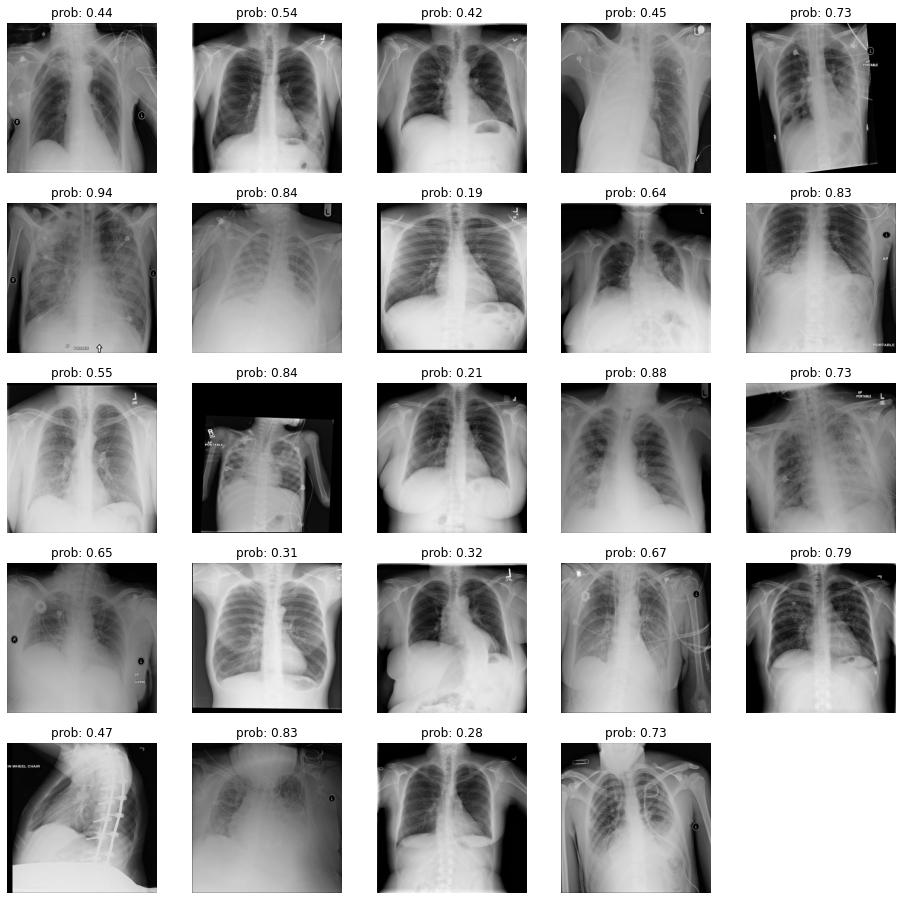

In [12]:
# plot
show_batch_and_prob(imgs_batch, avg_preds)

### now do the same with NO Findings images 

In [13]:
condition = all_xray_df['No Finding'] == 1.0

nofinding_df = all_xray_df[condition]

# we have only 1431 pneumonia images
nofinding_df.shape

(60361, 23)

In [14]:
# list of path of files for pneumonia images
nofinding_path_list = nofinding_df['path'].values

# select random N_IMAGES
N_IMAGES = BATCH_SIZE

# get N_IMAGES random indexes (out of. 1431)
idxs = sorted(random.sample(range(1, len(nofinding_path_list)), N_IMAGES))

# this is the reandom selected image list
selected_list = nofinding_path_list[idxs]

imgs = []

# read images and build the batch of N_IMAGES

for i in range(N_IMAGES):
    path_name = selected_list[i]
    
    img = cv2.imread(path_name)
    img = cv2.resize(img, (SIZE, SIZE), interpolation = cv2.INTER_AREA)
    
    imgs.append(img)

imgs_batch = build_batch_images(imgs)

# let's make a check
assert imgs_batch.shape == (N_IMAGES, SIZE, SIZE, 3)

In [15]:
# normalize
imgs_t_norm = preprocess_images(imgs_batch)

# do the predictions with the model
avg_preds = predict_batch(imgs_t_norm)

# expected labels all == 0 (we have selected all images with no finding)
labels_batch = np.zeros(N_IMAGES)

show_stats_for_batch(labels_batch, avg_preds, threshold=THRESHOLD)

Time (sec.) for predictions: 6.1

Stats for batch:
accuracy: 0.88
sensitivity: 0
tp: 0 ,tn: 21 ,fp: 3 ,fn: 0



### here we have evaluated only on No Finding, therefore negative cases. Accuracy is very good

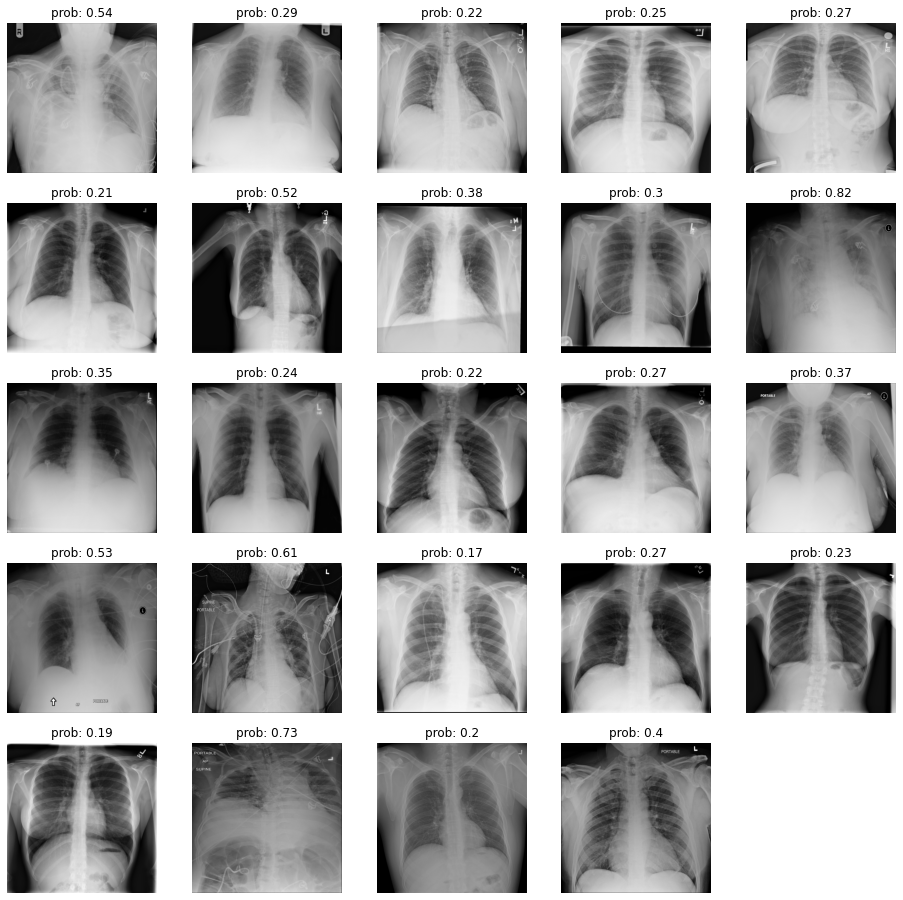

In [16]:
show_batch_and_prob(imgs_batch, avg_preds)